In [25]:
import os
import glob
import sys
from pydub import AudioSegment
from pydub.playback import play

# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Matplotlib
from matplotlib import pyplot as plt

# Numpy
import numpy as np
from numpy.linalg import norm
import pandas as pd

# Voice
import librosa
import librosa.display
from dtw import dtw

# Converting Data (.wav)

In [2]:
data_path = ['./voice_test_data_independent/']  # Path where the voice/video are located
data_path_save = ['./voice_test_data_independent_wav/']
extension_list = ('*.mpeg', '*.mp4','*.ogg')

In [3]:
# Convert data from '.mpeg', '.mp4','.ogg' to '.wav'
voice_dir = []
for path in data_path:
    for extension in extension_list:
        _list = sorted(glob.glob(path + extension))
        voice_dir += _list

for i in range(len(voice_dir)):
    wav_filename = data_path_save[0] + os.path.basename(voice_dir[i]).split('.')[0] + '.wav'
    AudioSegment.from_file(voice_dir[i]).export(wav_filename, format='wav')

In [4]:
sound = AudioSegment.from_file(wav_filename, format="wav")
play(sound)

In [6]:
wave_list =sorted(glob.glob(data_path_save[0] + '*.wav'))
wave_list

['./voice_test_data_independent_wav/voice_001_001_001.wav',
 './voice_test_data_independent_wav/voice_001_002_001.wav',
 './voice_test_data_independent_wav/voice_002_001_001.wav',
 './voice_test_data_independent_wav/voice_002_002_001.wav',
 './voice_test_data_independent_wav/voice_003_001_001.wav',
 './voice_test_data_independent_wav/voice_003_002_001.wav',
 './voice_test_data_independent_wav/voice_004_001_001.wav',
 './voice_test_data_independent_wav/voice_004_002_001.wav',
 './voice_test_data_independent_wav/voice_005_001_001.wav',
 './voice_test_data_independent_wav/voice_005_002_001.wav',
 './voice_test_data_independent_wav/voice_006_001_001.wav',
 './voice_test_data_independent_wav/voice_006_002_001.wav',
 './voice_test_data_independent_wav/voice_007_001_001.wav',
 './voice_test_data_independent_wav/voice_007_002_001.wav',
 './voice_test_data_independent_wav/voice_008_001_001.wav',
 './voice_test_data_independent_wav/voice_008_002_001.wav']

### ROC function

In [52]:
def calculate_results(predictions, labels):
    
    treshold_max = np.max(predictions)
    treshold_min = np.min(predictions)
    P = np.sum(labels == 1)
    N = np.sum(labels == 0)
    step = (treshold_max - treshold_min)/100
    TPR_full = []
    FPR_full = []
    ROC_ACC_full = []
    threshold_full = []
    #print('*****************************************************************************')
    for treshold in np.arange(treshold_min, treshold_max + step, step):
        
        #print(f'Treshold = {treshold:.4f}')
        idx1 = predictions <= treshold
        idx2 = predictions > treshold

        TP = np.sum(labels[idx1] == 1)
        FN = P - TP             
        TN = np.sum(labels[idx2] == 0)
        FP = N - TN
        #print(f'TP = {TP:.0f}, FN = {FN:.0f}, TN = {TN:.0f}, FP = {FP:.0f}')
        
        # roc curve
        TPR = float(TP/P)
        TPR_full.append(TPR)
        TNR = float(TN/N)
        FPR = 1-TNR
        FPR_full.append(FPR)
        ROC_ACC = (TP + TN)/(P + N)
        ROC_ACC_full.append(ROC_ACC)
        threshold_full.append(treshold)
        #print(f'TPR = {TPR:.4f}, FPR = {FPR:.4f}, ROC_ACC = {ROC_ACC:.4f}')
        
    return TPR_full, FPR_full, ROC_ACC_full, threshold_full

# Computer Vision Model (MFCC + DTW)

In [7]:
from tqdm import tqdm
mfcc_total = []
for i in tqdm(range(len(wave_list))):
    y, sr = librosa.load(wave_list[i])
    mfcc = librosa.feature.mfcc(y,sr)   #Computing MFCC values
    mfcc_total.append(mfcc)

100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


In [8]:
mfcc_total_labels = []
mfcc_total_dist =  []
for i in tqdm(range(len(wave_list)-1)):
    
    x = mfcc_total[i]
    lx = int(os.path.basename(wave_list[i]).split('_')[1])
    
    for j in range(i+1,len(wave_list)):
        
        y = mfcc_total[j]
        ly = int(os.path.basename(wave_list[j]).split('_')[1])
        
        dist, cost, acc_cost, path = dtw(x.T, y.T, dist=lambda x, y: norm(x - y, ord=2))
        mfcc_total_dist.append(dist)
        
        if lx == ly:
            label = int(1)
            mfcc_total_labels.append(label)
        else:
            label = int(0)
            mfcc_total_labels.append(label) 

100%|██████████| 15/15 [03:09<00:00, 12.64s/it]


In [10]:
print("mfcc total dist = " + str(len(mfcc_total_dist)))
print("mfcc total labels = " + str(len(mfcc_total_labels)))

mfcc total dist = 120
mfcc total labels = 120


In [11]:
mfcc_predictions = np.array([mfcc_total_dist])
mfcc_labels = np.array([mfcc_total_labels])

In [83]:
mfcc_TPR, mfcc_FPR, mfcc_accuracy, mfcc_threshold = calculate_results(mfcc_predictions, mfcc_labels)
#mfcc_FNR = 1 - mfcc_TPR
mfcc_FNR = [1-x for x in mfcc_TPR]

In [87]:
results_mfcc = pd.DataFrame(list(zip(mfcc_TPR, mfcc_FNR, mfcc_FPR, mfcc_accuracy, mfcc_threshold)), 
                            columns=['TPR','FNR', 'FPR','Accuracy','Threshold'])
results_mfcc.head(70).tail(20)

,TPR,FNR,FPR,Accuracy,Threshold
50,0.875,0.125,0.598214,0.433333,83047.263589
51,0.875,0.125,0.616071,0.416667,84095.354921
52,0.875,0.125,0.625000,0.408333,85143.446252
53,0.875,0.125,0.651786,0.383333,86191.537584
54,0.875,0.125,0.660714,0.375000,87239.628916
55,0.875,0.125,0.660714,0.375000,88287.720248
56,0.875,0.125,0.678571,0.358333,89335.811580
57,1.000,0.000,0.687500,0.358333,90383.902911
58,1.000,0.000,0.696429,0.350000,91431.994243
59,1.000,0.000,0.723214,0.325000,92480.085575


In [22]:
print("Accuracy = " + str(np.max(mfcc_accuracy)))

Accuracy = 0.9416666666666667


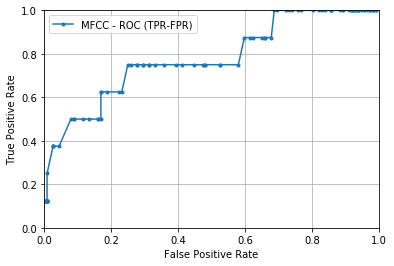

In [23]:
# plt.subplot(1, 2, 1)
# plot the roc curve for the model
plt.plot(mfcc_FPR, mfcc_TPR, marker='.', label='MFCC - ROC (TPR-FPR)')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
# show the legend
plt.legend()
# save and show plot
plt.savefig('MFCC Test Results.png')
plt.show()

In [ ]:
# #Showing multiple plots using subplot
# plt.subplot(2, 2, 1) 
# mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
# librosa.display.specshow(mfcc1)
# plt.subplot(2, 2, 2)
# mfcc2 = librosa.feature.mfcc(y2, sr2)
# librosa.display.specshow(mfcc2)

In [ ]:
# plt.imshow(cost.T, origin='lower', cmap=plt.get_cmap('gray'), interpolation='nearest')
# plt.plot(path[0], path[1], 'w')   #creating plot for DTW
# plt.xlim((-0.5, cost.shape[0]-0.5))
# plt.ylim((-0.5, cost.shape[1]-0.5))
# plt.show()  #To display the plots graphically

# CNN Model (Resemblyzer)

In [57]:
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path

In [58]:
# np.set_printoptions(precision=3, suppress=True)
encoder = VoiceEncoder()
embed_total = []
for i in tqdm(range(len(wave_list))):
    fpath = Path(wave_list[i])
    wav = preprocess_wav(fpath)
    embed = encoder.embed_utterance(wav)
    embed_total.append(embed)

  0%|          | 0/16 [00:00<?, ?it/s]

Loaded the voice encoder model on cuda in 2.30 seconds.


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


In [59]:
embed_total_labels = []
embed_total_dist =  []
f_dist = lambda x, y: norm(x - y, ord=2)
for i in tqdm(range(len(wave_list)-1)):
    
    x = embed_total[i]
    lx = int(os.path.basename(wave_list[i]).split('_')[1])
    
    for j in range(i+1,len(wave_list)):
        
        y = embed_total[j]
        ly = int(os.path.basename(wave_list[j]).split('_')[1])
        
        dist = f_dist(x,y)
        embed_total_dist.append(dist)
        
        if lx == ly:
            label = int(1)
            embed_total_labels.append(label)
        else:
            label = int(0)
            embed_total_labels.append(label) 

100%|██████████| 15/15 [00:00<00:00, 5156.93it/s]


In [60]:
print("embed total dist = " + str(len(embed_total_dist)))
print("embed total labels = " + str(len(embed_total_labels)))

embed total dist = 120
embed total labels = 120


In [61]:
embed_predictions = np.array([embed_total_dist])
embed_labels = np.array([embed_total_labels])

In [79]:
embed_TPR, embed_FPR, embed_accuracy, embed_threshold = calculate_results(embed_predictions, embed_labels)
#embed_FNR = 1 - embed_TPR
embed_FNR = [1-x for x in embed_TPR]

In [108]:
results_embed = pd.DataFrame(list(zip(embed_TPR, embed_FNR, embed_FPR, embed_accuracy, embed_threshold)), 
                            columns=['TPR','FNR','FPR','Accuracy','Threshold'])
results_embed.head(70).tail(20)

,TPR,FNR,FPR,Accuracy,Threshold
50,0.750,0.250,0.000000,0.983333,0.660681
51,0.875,0.125,0.000000,0.991667,0.668836
52,0.875,0.125,0.000000,0.991667,0.676991
53,0.875,0.125,0.008929,0.983333,0.685147
54,0.875,0.125,0.017857,0.975000,0.693302
55,0.875,0.125,0.026786,0.966667,0.701458
56,0.875,0.125,0.035714,0.958333,0.709613
57,0.875,0.125,0.035714,0.958333,0.717768
58,0.875,0.125,0.035714,0.958333,0.725924
59,0.875,0.125,0.053571,0.941667,0.734079


In [88]:
print("Resemblyzer accuracy = " + str(np.max(embed_accuracy)))

Resemblyzer accuracy = 0.9916666666666667


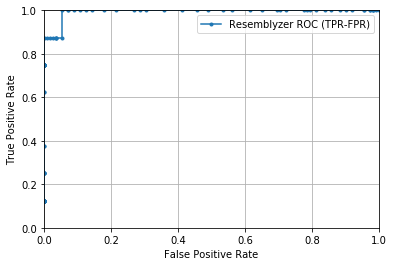

In [89]:
# plt.subplot(1, 2, 1)
# plot the roc curve for the model
plt.plot(embed_FPR, embed_TPR, marker='.', label='Resemblyzer ROC (TPR-FPR)')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
# show the legend
plt.legend()
# save and show plot
plt.savefig('Resemblyzer Test Results.png')
plt.show()

### Multi-Modal Voice Verification
(Computer Vision + Deep Learning)

In [90]:
def tanh_normalize(x):
    
    m = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    normalized_x = 0.5 * (np.tanh(0.01 * ((x - m) / std)) + 1)
    
    return normalized_x

In [91]:
embed_normalized = tanh_normalize(embed_predictions[-1])

In [92]:
mfcc_normalized = tanh_normalize(mfcc_predictions[-1])

In [95]:
# Exahustive Search
for i in np.arange(0, 1, 0.1):
    fusion_predictions = i*embed_normalized + (1-i)*mfcc_normalized
    fusion_predictions = np.array([fusion_predictions])
    fusion_labels = embed_labels
    fusion_TPR, fusion_FPR, fusion_accuracy, fusion_threshold = calculate_results(fusion_predictions, 
                                                                                  fusion_labels)
    print(f'weight = {i:0.1f} fusion accuracy = {np.max(fusion_accuracy):0.4f}')

weight = 0.0 fusion accuracy = 0.9417
weight = 0.1 fusion accuracy = 0.9583
weight = 0.2 fusion accuracy = 0.9750
weight = 0.3 fusion accuracy = 0.9833
weight = 0.4 fusion accuracy = 0.9833
weight = 0.5 fusion accuracy = 0.9917
weight = 0.6 fusion accuracy = 0.9917
weight = 0.7 fusion accuracy = 0.9917
weight = 0.8 fusion accuracy = 0.9917
weight = 0.9 fusion accuracy = 0.9917


In [102]:
fusion_predictions = 0.5*embed_normalized + 0.5*mfcc_normalized
fusion_predictions = np.array([fusion_predictions])
fusion_labels = embed_labels
fusion_TPR, fusion_FPR, fusion_accuracy, fusion_threshold = calculate_results(fusion_predictions, 
                                                                              fusion_labels)
print(f'fusion accuracy = {np.max(fusion_accuracy):0.4f}')

fusion accuracy = 0.9917


# Scores

In [103]:
import plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = embed_FPR, 
    y = embed_TPR,
    name="Resemblyzer"       # this sets its legend entry
))

fig.add_trace(go.Scatter(
    x = mfcc_FPR, 
    y = mfcc_TPR,
    name="MFCC"
))

fig.add_trace(go.Scatter(
    x = fusion_FPR, 
    y = fusion_TPR,
    name="Fusion"
))

fig.update_layout(
    
    title={
        'text': "Multi-Modal Voice Verification",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},

    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    
    font=dict(
        family="Arial, monospace",
        size=20,
        color="#000000"
    )
)

fig.show()

In [104]:
print(f'MFCC accuracy = {np.max(mfcc_accuracy):0.4f}')
print(f'Resemblyzer accuracy = {np.max(embed_accuracy):0.4f}')
print(f'Fusion accuracy = {np.max(fusion_accuracy):0.4f}')

MFCC accuracy = 0.9417
Resemblyzer accuracy = 0.9917
Fusion accuracy = 0.9917


# Process Time

In [105]:
import time

y1, sr1 = librosa.load(wave_list[1])
x = librosa.feature.mfcc(y1,sr1)

start = time.time()

y2, sr2 = librosa.load(wave_list[2])
y = librosa.feature.mfcc(y2,sr2) 
dist, cost, acc_cost, path = dtw(x.T, y.T, dist=lambda x, y: norm(x - y, ord=2))

print("MFCC Process Time= " + str(time.time() - start))

MFCC Process Time= 2.7486698627471924


In [106]:
encoder = VoiceEncoder()
import torch
# # device config
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fpath1 = Path(wave_list[1])
wav1 = preprocess_wav(fpath1)
embed1 = encoder.embed_utterance(wav1)

start = time.time()

fpath2 = Path(wave_list[2])
wav2 = preprocess_wav(fpath2)
embed2 = encoder.embed_utterance(wav2)

dist = f_dist(embed1,embed2)
print("Resemblyzer Process Time= " + str(time.time() - start))

Loaded the voice encoder model on cuda in 0.02 seconds.
Resemblyzer Process Time= 0.4197049140930176


## REFERENCES

https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/